In [ ]:
import pandas as pd
import numpy as np
import re
import keras
from tqdm import tqdm
import pickle as pkl
from tensorflow.keras import layers
import tensorflow as tf
import gc
from os import listdir
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
import multiprocessing
import xgboost as xgb
gc.enable()

import statsmodels.api as sm
import pylab as plt
from scipy import stats

from google.colab import drive
drive.mount('/content/drive')

###seq2seq

In [ ]:
epochs = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for name in listdir('/content/drive/My Drive/Colab Notebooks/Diplom/models/seq2seq/1'):
  epochs.append(int(name[15:18]))
  train_loss.append(float(name[24:29]))
  train_acc.append(float(name[39:44]))
  val_loss.append(float(name[53:58]))
  val_acc.append(float(name[71:76]))

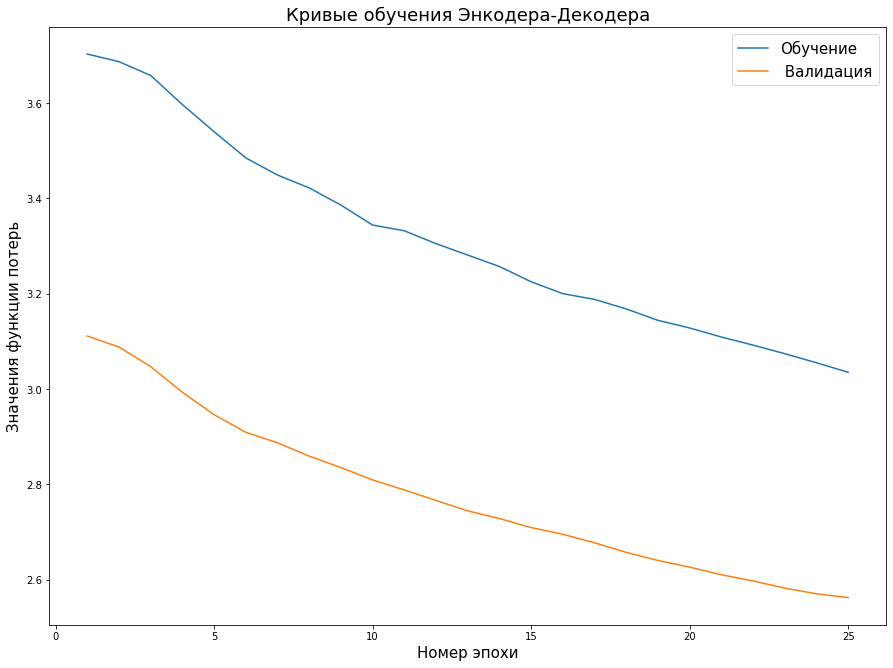

In [ ]:
plt.figure(figsize=(15,11))
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)
plt.title('Кривые обучения Энкодера-Декодера', fontsize=18)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значения функции потерь', fontsize=15)
plt.legend(['Обучение',' Валидация'], fontsize=15)

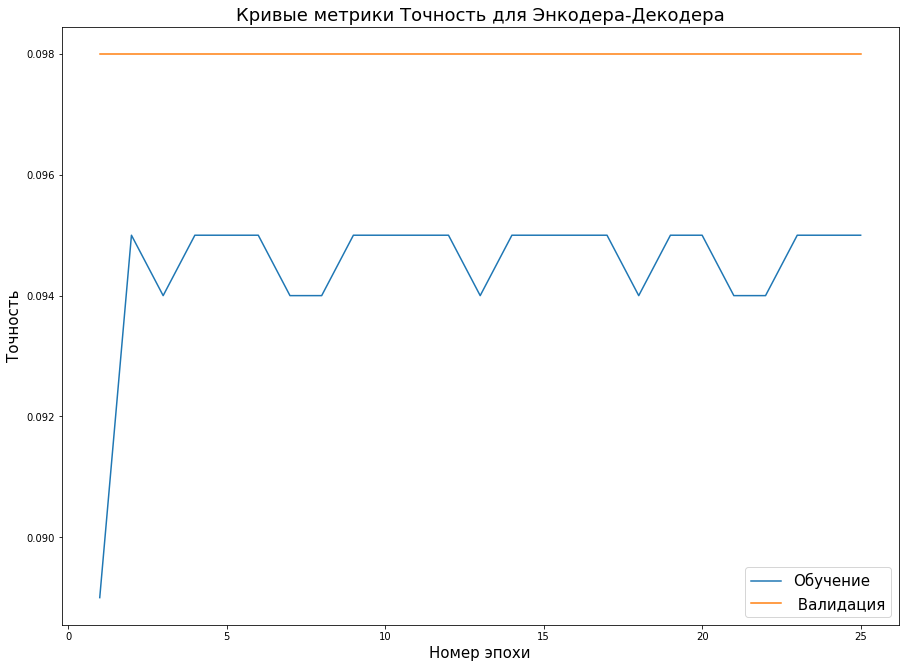

In [ ]:
plt.figure(figsize=(15,11))
plt.plot(epochs, train_acc)
plt.plot(epochs, val_acc)
plt.title('Кривые метрики Точность для Энкодера-Декодера', fontsize=18)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Точность', fontsize=15)
plt.legend(['Обучение',' Валидация'], fontsize=15)

###next sentence prediction

In [ ]:
epochs = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for name in listdir('/content/drive/My Drive/Colab Notebooks/Diplom/models/lstm_next_sentence_pred/1'):
  try:
    epochs.append(int(name[31:34]))
    train_loss.append(float(name[40:45]))
    train_acc.append(float(name[55:60]))
    val_loss.append(float(name[69:74]))
    val_acc.append(float(name[87:92]))
  except:pass

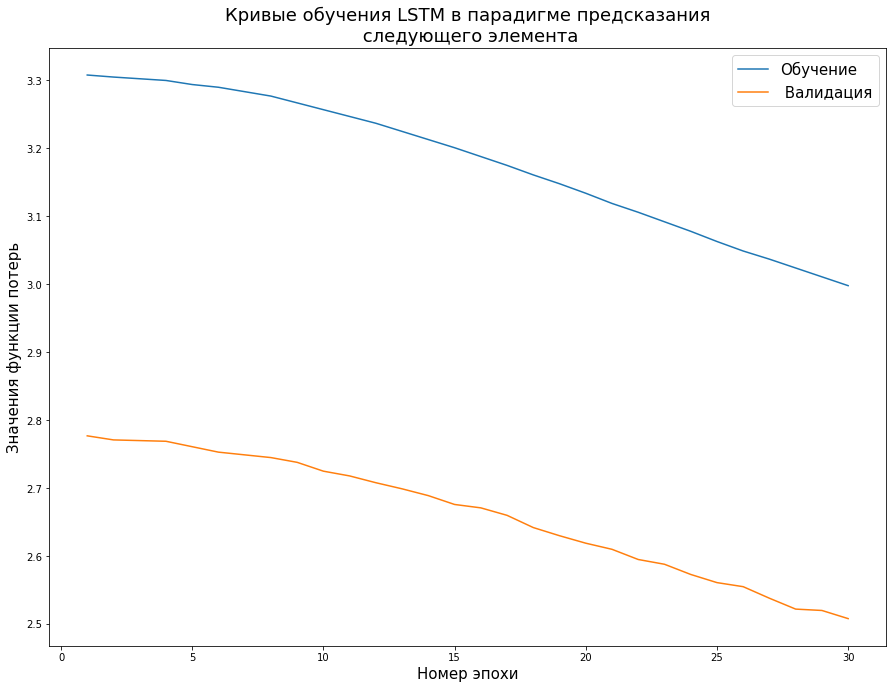

In [ ]:
plt.figure(figsize=(15,11))
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)
plt.title('Кривые обучения LSTM в парадигме предсказания\n следующего элемента', fontsize=18)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значения функции потерь', fontsize=15)
plt.legend(['Обучение',' Валидация'], fontsize=15)

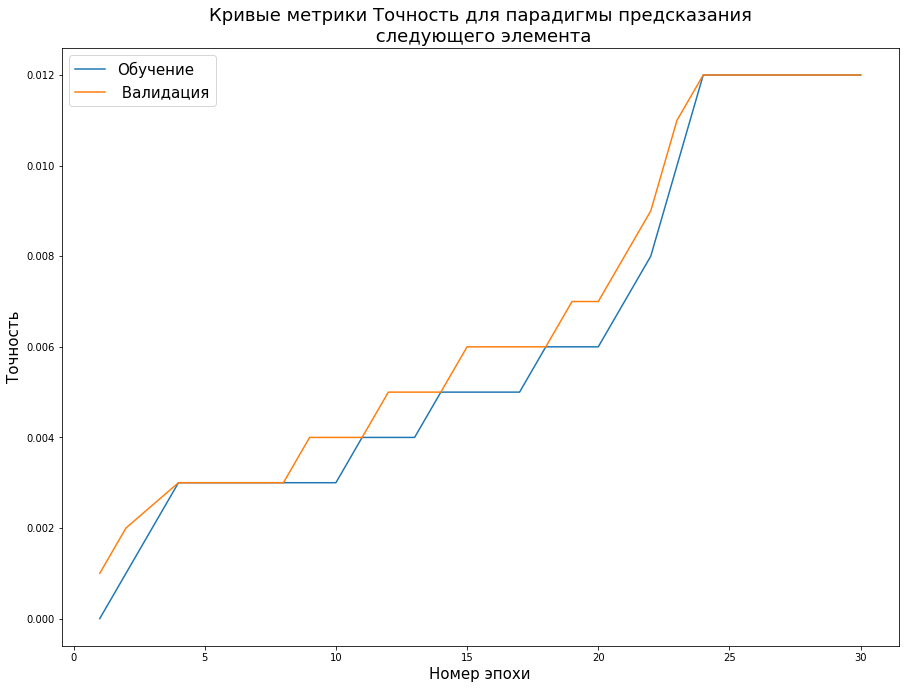

In [ ]:
plt.figure(figsize=(15,11))
plt.plot(epochs, train_acc)
plt.plot(epochs, val_acc)
plt.title('Кривые метрики Точность для парадигмы предсказания\n следующего элемента', fontsize=18)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Точность', fontsize=15)
plt.legend(['Обучение',' Валидация'], fontsize=15)

###simple lstm

In [ ]:
epochs = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for name in listdir('/content/drive/My Drive/Colab Notebooks/Diplom/models/simple_lstm/1'):
  try:
    epochs.append(int(name[23:24]))
    train_loss.append(float(name[51:56]))
    train_acc.append(float(name[66:71]))
    val_loss.append(float(name[80:85]))
    val_acc.append(float(name[93:98]))
  except:
    epochs.append(int(name[23:25]))
    train_loss.append(float(name[52:57]))
    train_acc.append(float(name[67:72]))
    val_loss.append(float(name[81:86]))
    val_acc.append(float(name[94:99]))

epochs = range(1, 11)

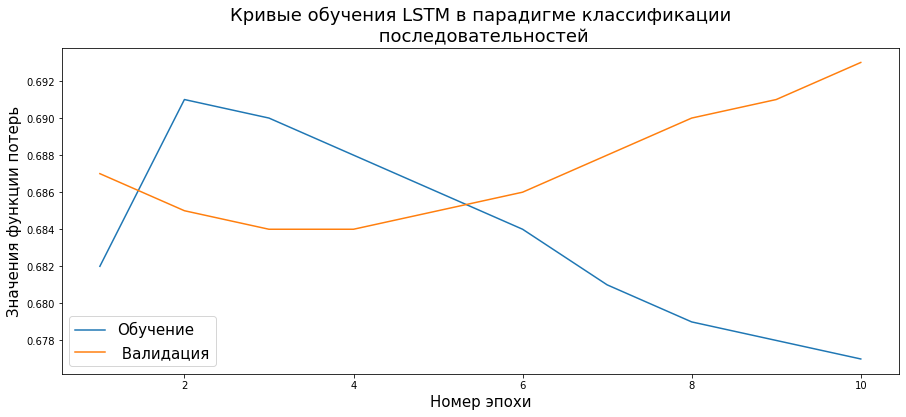

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)
plt.title('Кривые обучения LSTM в парадигме классификации\n последовательностей', fontsize=18)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значения функции потерь', fontsize=15)
plt.legend(['Обучение',' Валидация'], fontsize=15)

###Считываем данные

In [ ]:
precision_without = {}
precision_w2v = {}
precision_fasttext = {}
precision_elmo = {}
precision_bert = {}
precision_laser = {}


recall_without = {}
recall_w2v = {}
recall_fasttext = {}
recall_elmo = {}
recall_bert = {}
recall_laser = {}

for i in range(1, 11):
  precision_without[i] = []
  precision_w2v[i] = []
  precision_fasttext[i] = []
  precision_elmo[i] = []
  precision_bert[i] = []
  precision_laser[i] = []

  recall_without[i] = []
  recall_w2v[i] = []
  recall_fasttext[i] = []
  recall_elmo[i] = []
  recall_bert[i] = []
  recall_laser[i] = []

for i in range(1, 11):
  with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}/metric_without_w2v_feats.pkl'.format(i), 'rb') as f:
    metric_without = pkl.load(f)
  prec, rec = metric_without[i]
  for key, val in prec.items():
    precision_without[key].append(val)
  for key, val in rec.items():
    recall_without[key].append(val)

  with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}/metric_with_w2v_feats.pkl'.format(i), 'rb') as f:
    metric_w2v = pkl.load(f)
  prec_w2v, rec_w2v = metric_w2v[i]
  for key, val in prec_w2v.items():
    precision_w2v[key].append(val)
  for key, val in rec_w2v.items():
    recall_w2v[key].append(val)

  with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/fasttext/{0}/metric_with_fasttext_feats.pkl'.format(i), 'rb') as f:
    metric_fasttext = pkl.load(f)
  prec_fasttext, rec_fasttext = metric_fasttext[i]
  for key, val in prec_fasttext.items():
    precision_fasttext[key].append(val)
  for key, val in rec_fasttext.items():
    recall_fasttext[key].append(val)

  with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/elmo/{0}/metric_with_elmo_feats.pkl'.format(i), 'rb') as f:
    metric_elmo = pkl.load(f)
  prec_elmo, rec_elmo = metric_elmo[i]
  for key, val in prec_elmo.items():
    precision_elmo[key].append(val)
  for key, val in rec_elmo.items():
    recall_elmo[key].append(val)

  with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/bert/{0}/metric_with_bert_feats.pkl'.format(i), 'rb') as f:
    metric_bert = pkl.load(f)
  prec_bert, rec_bert = metric_bert[i]
  for key, val in prec_bert.items():
    precision_bert[key].append(val)
  for key, val in rec_bert.items():
    recall_bert[key].append(val)

  with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/laser/{0}/metric_with_laser_feats.pkl'.format(i), 'rb') as f:
    metric_laser = pkl.load(f)
  prec_laser, rec_laser = metric_laser[i]
  for key, val in prec_laser.items():
    precision_laser[key].append(val)
  for key, val in rec_laser.items():
    recall_laser[key].append(val)

### Доверительные интервалы

In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return [m, h]

In [ ]:
st = ''
for i in range(1, 11):
  m, h = mean_confidence_interval(recall_laser[i])
  m = np.round(m, decimals=3)
  h = np.round(h, decimals=3)
  st += ' ${0} \pm {1}$ &'.format(m ,h)

print(st)

 $0.08 \pm 0.001$ & $0.136 \pm 0.001$ & $0.181 \pm 0.002$ & $0.221 \pm 0.002$ & $0.254 \pm 0.003$ & $0.284 \pm 0.003$ & $0.313 \pm 0.003$ & $0.339 \pm 0.004$ & $0.362 \pm 0.004$ & $0.384 \pm 0.004$ &


###Проверка на нормальность

In [ ]:
shapiro_without = []
shapiro_w2v = []
shapiro_fasttext = []
shapiro_elmo = []
shapiro_bert = []
shapiro_laser = []

for i in range(1, 11):
  shapiro_without.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(precision_without[i]))))[1])
  shapiro_w2v.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(precision_w2v[i]))))[1])
  shapiro_fasttext.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(precision_fasttext[i]))))[1])
  shapiro_elmo.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(precision_elmo[i]))))[1])
  shapiro_bert.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(precision_bert[i]))))[1])
  shapiro_laser.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(precision_laser[i]))))[1])

In [ ]:
st = 'LASER & '
for el in shapiro_laser:
  st += '$' + str(el) + '$ & '

In [ ]:
st

'LASER & $0.0$ & $0.015$ & $0.025$ & $0.039$ & $0.092$ & $0.217$ & $0.37$ & $0.555$ & $0.735$ & $0.806$ & '

In [ ]:
shapiro_without = []
shapiro_w2v = []
shapiro_fasttext = []
shapiro_elmo = []
shapiro_bert = []
shapiro_laser = []

for i in range(1, 11):
  shapiro_without.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(recall_without[i]))))[1])
  shapiro_w2v.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(recall_w2v[i]))))[1])
  shapiro_fasttext.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(recall_fasttext[i]))))[1])
  shapiro_elmo.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(recall_elmo[i]))))[1])
  shapiro_bert.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(recall_bert[i]))))[1])
  shapiro_laser.append(tuple(map(lambda x: np.round(x, decimals=3), stats.shapiro(np.array(recall_laser[i]))))[1])

In [ ]:
st = 'LASER & '
for el in shapiro_laser:
  st += '$' + str(el) + '$ & '

print(st)

LASER & $0.005$ & $0.063$ & $0.312$ & $0.11$ & $0.428$ & $0.579$ & $0.599$ & $0.713$ & $0.734$ & $0.499$ & 


###Статистическая значимость различий

In [ ]:
stats.ttest_rel(precision_without[1], precision_w2v[1])[1]

0.6394565053504532

In [ ]:
st = ''
for i in range(1, 11):
  p_val = np.round(stats.ttest_rel(recall_without[i], recall_laser[i])[1], decimals=3)
  st +='${0}$ & '.format(p_val)

print(st)

$0.159$ & $0.194$ & $0.113$ & $0.136$ & $0.089$ & $0.079$ & $0.134$ & $0.181$ & $0.2$ & $0.253$ & 


Text(0.5, 1.0, 'Диаграмма размаха для метрики Точность при k=1')

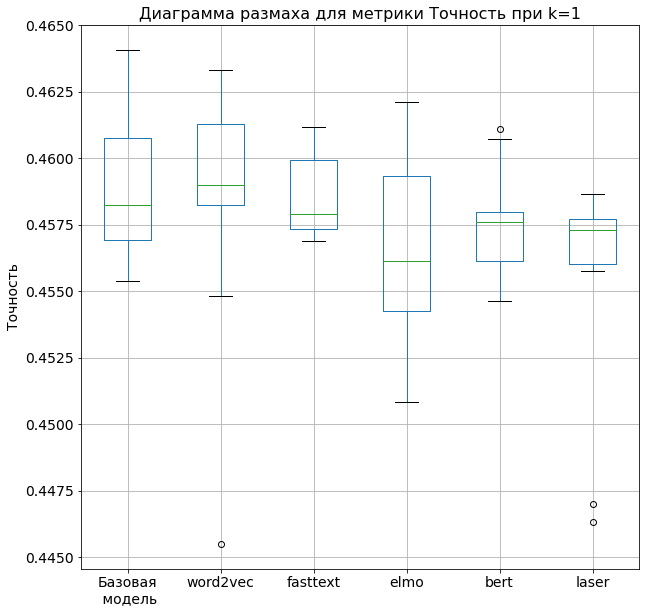

In [ ]:
k = 1

without_df = pd.DataFrame(np.reshape(precision_without[k], (-1,)), columns=['Базовая\n модель'])
w2v_df = pd.DataFrame(np.reshape(precision_w2v[k], (-1,)), columns=['word2vec'])
fasttext_df = pd.DataFrame(np.reshape(precision_fasttext[k], (-1,)), columns=['fasttext'])
elmo_df = pd.DataFrame(np.reshape(precision_elmo[k], (-1,)), columns=['elmo'])
bert_df = pd.DataFrame(np.reshape(precision_bert[k], (-1,)), columns=['bert'])
laser_df = pd.DataFrame(np.reshape(precision_laser[k], (-1,)), columns=['laser'])

box_plot_df = pd.concat((without_df, w2v_df, fasttext_df, elmo_df, bert_df, laser_df), axis=1)

box_plot_df.plot.box(grid=True, figsize=(10,10), fontsize=14)
plt.ylabel('Точность', fontsize=14)
plt.title('Диаграмма размаха для метрики Точность при k={0}'.format(k), fontsize=16)

Text(0.5, 1.0, 'Диаграмма размаха для метрики Полнота при k=1')

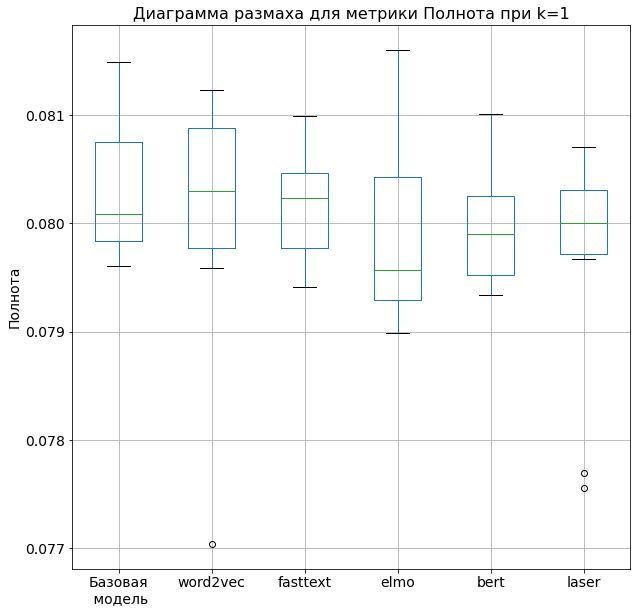

In [ ]:
k = 1

without_df = pd.DataFrame(np.reshape(recall_without[k], (-1,)), columns=['Базовая\n модель'])
w2v_df = pd.DataFrame(np.reshape(recall_w2v[k], (-1,)), columns=['word2vec'])
fasttext_df = pd.DataFrame(np.reshape(recall_fasttext[k], (-1,)), columns=['fasttext'])
elmo_df = pd.DataFrame(np.reshape(recall_elmo[k], (-1,)), columns=['elmo'])
bert_df = pd.DataFrame(np.reshape(recall_bert[k], (-1,)), columns=['bert'])
laser_df = pd.DataFrame(np.reshape(recall_laser[k], (-1,)), columns=['laser'])

box_plot_df = pd.concat((without_df, w2v_df, fasttext_df, elmo_df, bert_df, laser_df), axis=1)

box_plot_df.plot.box(grid=True, figsize=(10,10), fontsize=14)
plt.ylabel('Полнота', fontsize=14)
plt.title('Диаграмма размаха для метрики Полнота при k={0}'.format(k), fontsize=16)